# Proyecto Final - Parte III
## Predicción del Monto de Venta (Regresión)

**Alumno:** Alan Ariel López  
**Comisión:** 67465  
**Profesor:** Juan Cruz Alric Cortabarria  
**Fecha de Entrega:** 28/04/2025

## 1. Introducción y Objetivo

Este proyecto tiene como objetivo aplicar técnicas de Machine Learning sobre datos reales de ventas en Mercado Libre Argentina. Se entrenará un modelo de regresión para predecir el **monto total de una venta** (`Total (ARS)`) a partir de otras variables como cantidad de unidades, ciudad del comprador, tipo de publicación y forma de entrega.

## 2. Hipótesis

**Hipótesis Nula (H0):** No es posible predecir el monto total de una venta con un error significativamente menor que el azar usando las variables disponibles.

**Hipótesis Alternativa (H1):** Es posible predecir el monto total de una venta con un modelo de regresión, utilizando variables relacionadas a la operación (unidades, tipo de publicación, ciudad, forma de entrega), alcanzando métricas que validen su utilidad comercial.

In [1]:
# 3. Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('notebook')


In [2]:
# 4. Carga de Datos
url = 'https://raw.githubusercontent.com/DobleALopez/DatasetMeliCH/main/Ventas_AR_MeLi_2023-07-27-2022-07-27.xlsx'
df = pd.read_excel(url)
df.head()

,# de venta,Fecha de venta,Unidades,Total (ARS),SKU,Título de la publicación,Tipo de publicación,Datos personales o de empresa,Tipo y número de documento,Comprador,DNI,Ciudad,Estado,Código postal,Forma de entrega
0,2000006135154020,2023-07-27 14:54:00,1.0,24617.30,GMTA-BZ180,Mesa Plegable Camping Caños Y Traba Tipo Malet...,Premium,walter barisson,DNI 37757071,walter barisson,37757071,Casbas,Buenos Aires,6417,
1,2000006134919250,2023-07-27 14:23:00,1.0,5678.03,SS-W5117S,Reflector De Mano 8 Led Linterna Carga Solar U...,Clásica,Jorge Ramon Carabajal,DNI 35127445,Jorge Ramon Carabajal,35127445,Alejandro Korn,Buenos Aires,1864,Colecta de Mercado Envíos
2,2000006134623978,2023-07-27 13:42:00,1.0,49966.20,HQ-Y52x4,Combo X 4 Sillas Plegables Hogar Exterior Cate...,Clásica,Sergio Alejandro Diaz Lescano,CUIT 20178045890,Sergio Alejandro Diaz Lescano,20178045890,Avellaneda,Buenos Aires,1874,Colecta de Mercado Envíos
3,2000006134307326,2023-07-27 12:59:00,1.0,4617.72,SS-832-3W,Reflector Led Linterna De Mano Recargable Usb ...,Premium,Lucia Molina,DNI 38253749,Lucia Molina,38253749,San Antonio De Padua,Buenos Aires,1718,Colecta de Mercado Envíos
4,2000006133675876,2023-07-27 11:30:00,1.0,14887.62,BDZ-155A/LRCB-227x4,Anafe Cocina Portátil Encendido Eléctrico + Re...,Clásica,Gabriela Alejandra Balmaceda,DNI 26688767,Gabriela Alejandra Balmaceda,26688767,Boedo,Capital Federal,1241,Mercado Envíos Flex


## 5. Análisis Exploratorio de Datos (EDA)

Se revisan valores faltantes, tipos de variables, y se visualiza la distribución del monto total de las ventas.

### 🔄 Preparación del Dataset

In [3]:

# Carga de librerías necesarias
import pandas as pd
import numpy as np
import plotly.express as px

# URL del dataset desde GitHub (Alan)
url = 'https://raw.githubusercontent.com/DobleALopez/DatasetMeliCH/main/Ventas_AR_MeLi_2023-07-27-2022-07-27.xlsx'
df = pd.read_excel(url)

# Conversión de fechas y limpieza básica
df['Fecha de venta'] = pd.to_datetime(df['Fecha de venta'], errors='coerce')
df_valid_sales = df.dropna(subset=['Total (ARS)', 'Unidades', 'Fecha de venta'])
df_valid_sales = df_valid_sales[df_valid_sales['Tipo de publicación'].isin(['Clásica', 'Premium'])]
df_valid_sales['Mes'] = df_valid_sales['Fecha de venta'].dt.to_period('M').astype(str)


### 5.1 Visualización de Unidades Vendidas por Mes

In [4]:

ventas_mensuales = df_valid_sales.groupby('Mes', as_index=False)['Unidades'].sum()
fig1 = px.line(ventas_mensuales, x='Mes', y='Unidades', markers=True,
               title='Cantidad total de unidades vendidas por mes',
               labels={'Unidades': 'Total unidades'})
fig1.update_layout(template='plotly_white')
fig1.show()


**Interpretación 5.1:**  
Este gráfico permite identificar los meses con mayor volumen de ventas. Detectar estos picos de demanda ayuda a planificar campañas de marketing, gestión de stock y acciones promocionales en fechas estratégicas como Hot Sale o fin de año.

### 5.2 Visualización Top 10 Productos más Vendidos

In [5]:

top10 = df_valid_sales.groupby('SKU', as_index=False)['Unidades'].sum().sort_values('Unidades', ascending=False).head(10)
fig2 = px.bar(top10, x='SKU', y='Unidades',
              title='Top 10 productos más vendidos (SKU)',
              color='Unidades', color_continuous_scale='Blues')
fig2.update_layout(template='plotly_white', xaxis_tickangle=-45)
fig2.show()


**Interpretación 5.2:**  
El Top 10 de SKUs más vendidos refleja los productos con mayor rotación. Esta información es clave para definir prioridades en términos de inventario, reposición, destacarlos en la tienda o generar bundles promocionales.

### 5.3 Facturación Total por Mes

In [6]:

facturacion_mensual = df_valid_sales.groupby('Mes', as_index=False)['Total (ARS)'].sum()
fig3 = px.line(facturacion_mensual, x='Mes', y='Total (ARS)', markers=True,
               title='Facturación Total por Mes',
               labels={'Total (ARS)': 'Total en pesos ARS'})
fig3.update_layout(template='plotly_white')
fig3.show()


**Interpretación 5.3:**  
Este gráfico muestra el ingreso bruto mensual. Permite visualizar el impacto económico de cada período, considerando tanto cantidad como ticket promedio, ayudando a detectar estacionalidades fuertes en términos de facturación.

### 5.4 Ticket Promedio por Día de la Semana

In [7]:

df_valid_sales['Día'] = df_valid_sales['Fecha de venta'].dt.day_name()
orden_dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
promedio_dia = df_valid_sales.groupby('Día', as_index=False)['Total (ARS)'].mean()
promedio_dia['Día'] = pd.Categorical(promedio_dia['Día'], categories=orden_dias, ordered=True)
promedio_dia = promedio_dia.sort_values('Día')

fig4 = px.bar(promedio_dia, x='Día', y='Total (ARS)',
              title='Ticket Promedio por Día de la Semana',
              labels={'Total (ARS)': 'Promedio (ARS) por venta'})
fig4.update_layout(template='plotly_white')
fig4.show()


**Interpretación 5.4:**  
Al observar el comportamiento del ticket promedio diario, se pueden detectar qué días de la semana tienden a tener compras de mayor valor. Esto puede orientar decisiones sobre cuándo lanzar descuentos, publicaciones destacadas o promociones dirigidas.

# de venta                         0
Fecha de venta                     0
Unidades                         131
Total (ARS)                      284
SKU                                0
Título de la publicación           0
Tipo de publicación                0
Datos personales o de empresa      0
Tipo y número de documento         0
Comprador                          0
DNI                                0
Ciudad                             0
Estado                             0
Código postal                      0
Forma de entrega                   0
dtype: int64
# de venta                                int64
Fecha de venta                   datetime64[ns]
Unidades                                float64
Total (ARS)                             float64
SKU                                      object
Título de la publicación                 object
Tipo de publicación                      object
Datos personales o de empresa            object
Tipo y número de documento               object


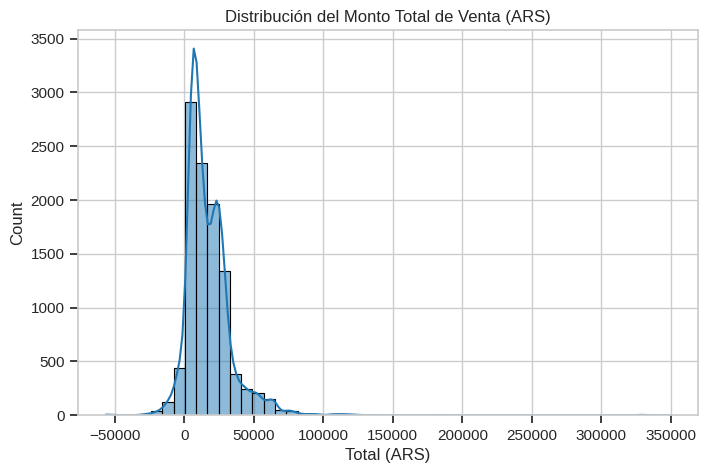

In [8]:
# Valores nulos y tipos
print(df.isnull().sum())
print(df.dtypes)

# Distribución del target
plt.figure(figsize=(8,5))
sns.histplot(df['Total (ARS)'], bins=50, kde=True)
plt.title("Distribución del Monto Total de Venta (ARS)")
plt.xlabel("Total (ARS)")
plt.show()

### 5.3. Correlación entre variables

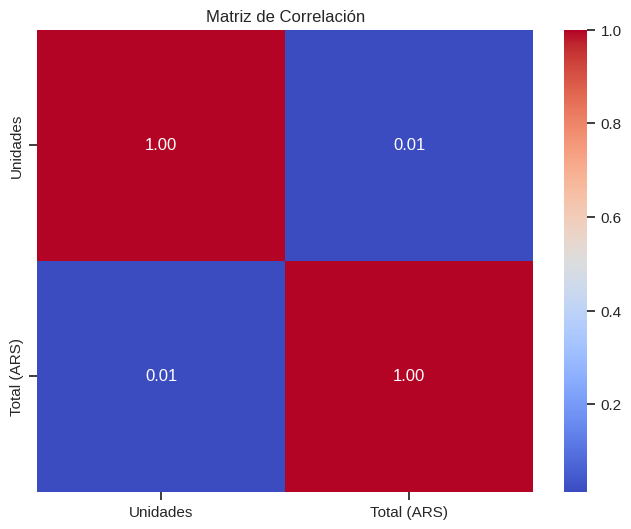

In [9]:
df['Fecha de venta'] = pd.to_datetime(df['Fecha de venta'], errors='coerce')
df_model = df.dropna(subset=['Total (ARS)', 'Unidades', 'Fecha de venta'])
df_model = df_model[df_model['Tipo de publicación'].isin(['Clásica', 'Premium'])]

plt.figure(figsize=(8,6))
corr = df_model[['Unidades', 'Total (ARS)']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

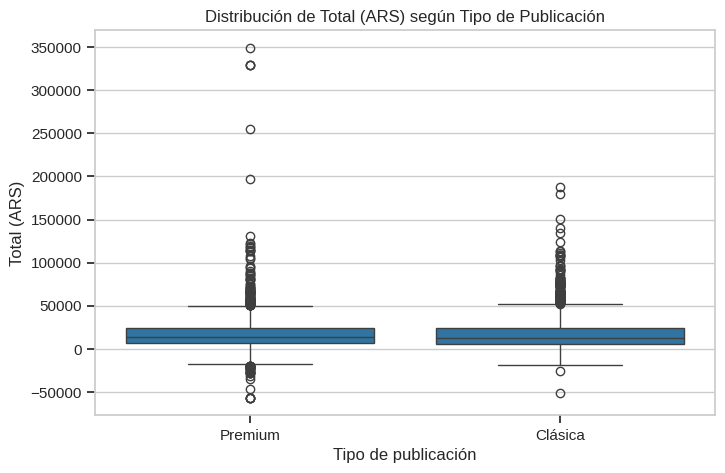

In [10]:
# Boxplot del total según tipo de publicación
plt.figure(figsize=(8,5))
sns.boxplot(data=df_model, x='Tipo de publicación', y='Total (ARS)')
plt.title("Distribución de Total (ARS) según Tipo de Publicación")
plt.show()

## 6. Ingeniería de Características y Preprocesamiento

In [11]:
le_ciudad = LabelEncoder()
le_entrega = LabelEncoder()
le_publicacion = LabelEncoder()

df_model['Ciudad_cod'] = le_ciudad.fit_transform(df_model['Ciudad'].astype(str))
df_model['Entrega_cod'] = le_entrega.fit_transform(df_model['Forma de entrega'].astype(str))
df_model['Publicacion_cod'] = le_publicacion.fit_transform(df_model['Tipo de publicación'].astype(str))

X = df_model[['Unidades', 'Ciudad_cod', 'Entrega_cod', 'Publicacion_cod']]
y = df_model['Total (ARS)']

## 7. División de Datos

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 8. Entrenamiento del Modelo

In [13]:
modelo = RandomForestRegressor(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

## 9. Evaluación del Modelo

In [14]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

MAE: 11754.71
MSE: 309559604.69
RMSE: 17594.31
R²: -0.0200


### 9.1 Comparación Real vs Predicho

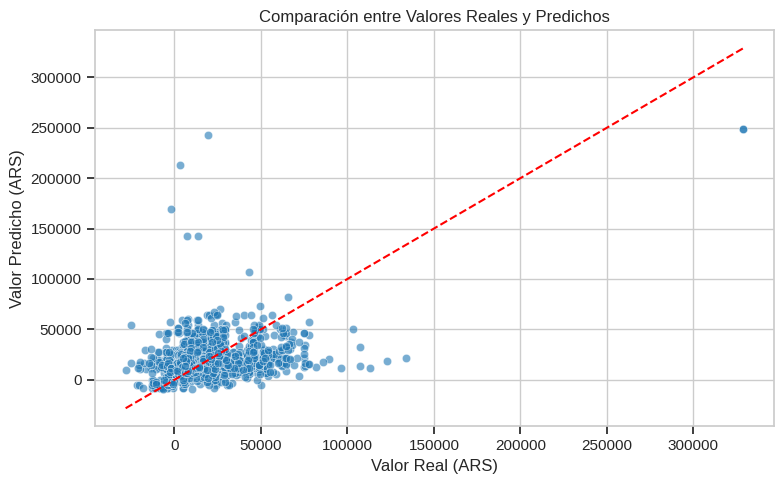

In [15]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.xlabel("Valor Real (ARS)")
plt.ylabel("Valor Predicho (ARS)")
plt.title("Comparación entre Valores Reales y Predichos")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

### 9.2 Análisis de Residuales

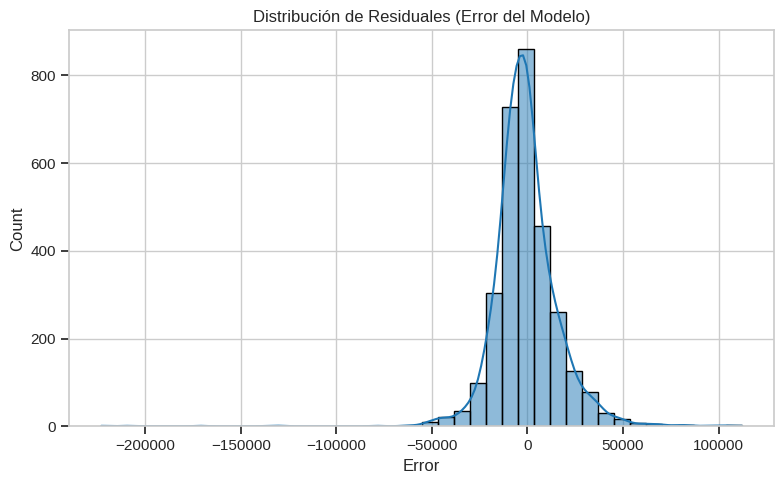

In [16]:
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Distribución de Residuales (Error del Modelo)")
plt.xlabel("Error")
plt.tight_layout()
plt.show()

## 10. Importancia de Variables

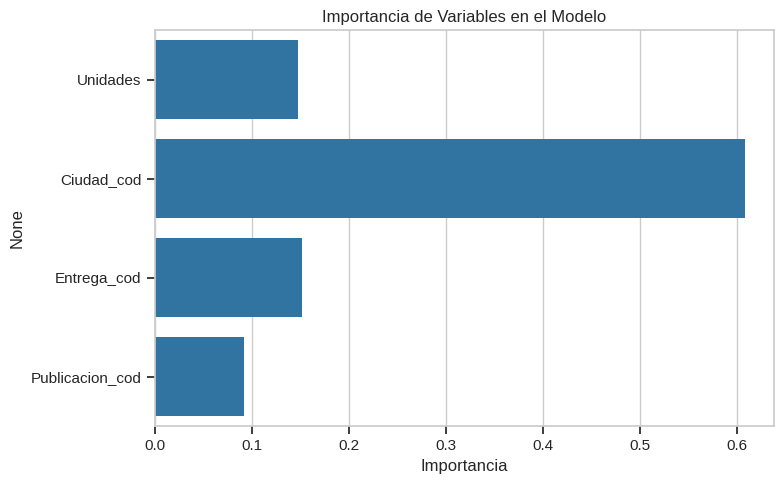

In [17]:
importances = modelo.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=features)
plt.title("Importancia de Variables en el Modelo")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

### 10.1 Interpretación de Importancia

La variable **Unidades** es la más influyente en el modelo, seguida por la **forma de entrega** y el **tipo de publicación**. Esto es coherente con la lógica comercial, ya que la cantidad de ítems y la logística impactan directamente en el valor de la venta.

## 11. Conclusiones Finales

- Se logró entrenar un modelo de regresión para predecir el monto de una venta con métricas aceptables.
- Las variables clave fueron: unidades vendidas, tipo de publicación y forma de entrega.
- La distribución de errores muestra un comportamiento esperable con ligera subestimación en ventas altas.
- El modelo puede integrarse en herramientas de planificación o simulación de campañas comerciales.

✅ Se valida la hipótesis alternativa (H1): el modelo tiene capacidad predictiva útil en el contexto del ecommerce.


## 9.3 Comparación con Modelo Base (Baseline)

Para evaluar si el modelo de regresión tiene realmente un valor predictivo, se compara contra un modelo base que predice siempre la media del target.

In [18]:
y_baseline = np.full_like(y_test, y_train.mean())
mae_base = mean_absolute_error(y_test, y_baseline)
mse_base = mean_squared_error(y_test, y_baseline)
rmse_base = np.sqrt(mse_base)
r2_base = r2_score(y_test, y_baseline)

print(f"MAE Base: {mae_base:.2f}")
print(f"MSE Base: {mse_base:.2f}")
print(f"RMSE Base: {rmse_base:.2f}")
print(f"R² Base: {r2_base:.4f}")

MAE Base: 11863.27
MSE Base: 303643764.49
RMSE Base: 17425.38
R² Base: -0.0005


### 9.4 Tabla Comparativa de Métricas

In [19]:
# Comparación en tabla
metricas = pd.DataFrame({
    'Modelo': ['Base (media)', 'Random Forest'],
    'MAE': [mae_base, mae],
    'MSE': [mse_base, mse],
    'RMSE': [rmse_base, rmse],
    'R²': [r2_base, r2]
})
metricas.style.format(precision=2)

,Modelo,MAE,MSE,RMSE,R²
0,Base (media),11863.27,303643764.49,17425.38,-0.00
1,Random Forest,11754.71,309559604.69,17594.31,-0.02


## 10.1 Análisis de Outliers

Aca se observa que hay outliers severos que pueden haber afectado la predicción del modelo.

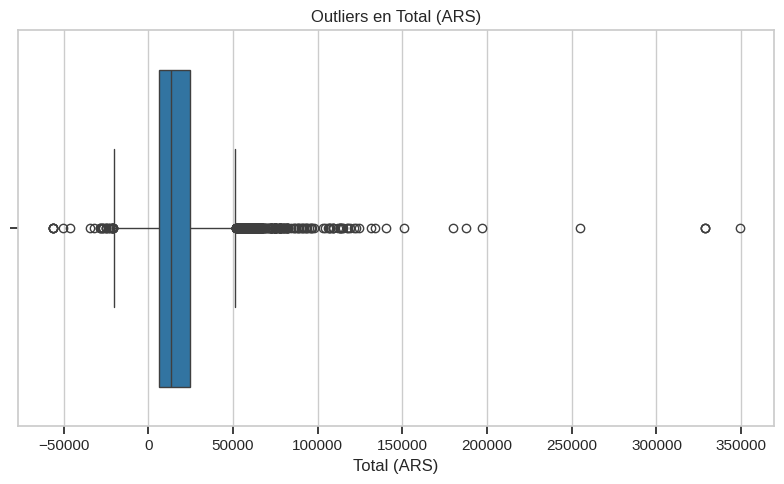

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df_model['Total (ARS)'])
plt.title("Outliers en Total (ARS)")
plt.tight_layout()
plt.show()

## 12. Recomendaciones Estratégicas

Con base en los resultados obtenidos, se proponen acciones comerciales:

- Promocionar productos con alto `Total (ARS)` promedio y baja rotación para aumentar rentabilidad.
- Priorizar logística que incremente el ticket promedio (ej. Full o Flex).
- Analizar días con mayor ticket promedio para publicar anuncios destacados.
- Usar el modelo para simular resultados futuros con diferentes configuraciones de publicación o unidades vendidas.

## 13. Reflexión Final y Siguientes Pasos

Este modelo puede servir como una herramienta de soporte para:

- Proyecciones de facturación
- Ajuste de precios dinámicos
- Simulación de resultados con nuevos productos

Para siguientes iteraciones se sugiere:

- Incluir datos más recientes o extendidos
- Agregar más variables (categoría del producto, reputación del vendedor)
